In [1]:
import numpy as np
import pandas as pd
from array import array
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import anndata as ad
import phagepy as pp
import scanpy as sc
import scipy.stats as ss
import scipy
import phagepy.analysis as analysis
import re
import os
from collections import Counter
import scipy.stats as stats
from Bio import SeqIO

In [2]:
# define output folder for figures
fig_dir='/path/to/output_figs/'

In [3]:
# define directory for source and output files
dir='/path/to/source_files/'

# Read/write

In [4]:
# load processed adata objects
cbm = sc.read_h5ad(dir+'01_cbm.h5ad')
bd = sc.read_h5ad(dir+'01_bd.h5ad')

In [5]:
# load chagas-specific peptide files
chagas_pept_cbm=pd.read_csv(dir+'01_cbm_pept.csv', index_col=0, header=0)
chagas_pept_bd=pd.read_csv(dir+'01_bd_pept.csv', index_col=0, header=0)

# Fig 2 a and b - heatmap
Plot all hits with seroprevalence > 15%

In [6]:
# create custom cmap
colors = ["#ebf3fb", "#08345e"]

custom_cmap = LinearSegmentedColormap.from_list("smooth_cmap", colors, N=256)

## BD

In [7]:
# subset BD-enriched peptides into only those reactive in at least 15% of specimens
filtered_bd = chagas_pept_bd[chagas_pept_bd['perc_test'] > 15]
filtered_bd.shape

(1228, 9)

In [8]:
# get list of peptide names - this list will correspond to var_names in adata object
bd_names=filtered_bd.sort_values(by='protein',ascending=False).index

# subset adata object for plotting - extract only seropos and seroneg samples, and only peptides enriched in seropos
subset_bd = bd[bd.obs['sero'].isin(['seropositive', 'seronegative']), bd_names]

# generate df for plotting - will contain sample ids, z-scores, and peptide names
df_bd = pd.DataFrame(data=subset_bd.layers['z_score'], 
                             index=subset_bd.obs.index, 
                             columns=bd_names)
df_bd = df_bd.T

# sort samples by serologic status and by geographic region
sorted_obs = subset_bd.obs.sort_values(by=['group', 'region'], ascending=True)
df_bd = df_bd[sorted_obs.index]

# replace z-scores below 5 with 0 for clear plotting of negatives
df_bd = df_bd.where(df_bd > 5, 0)

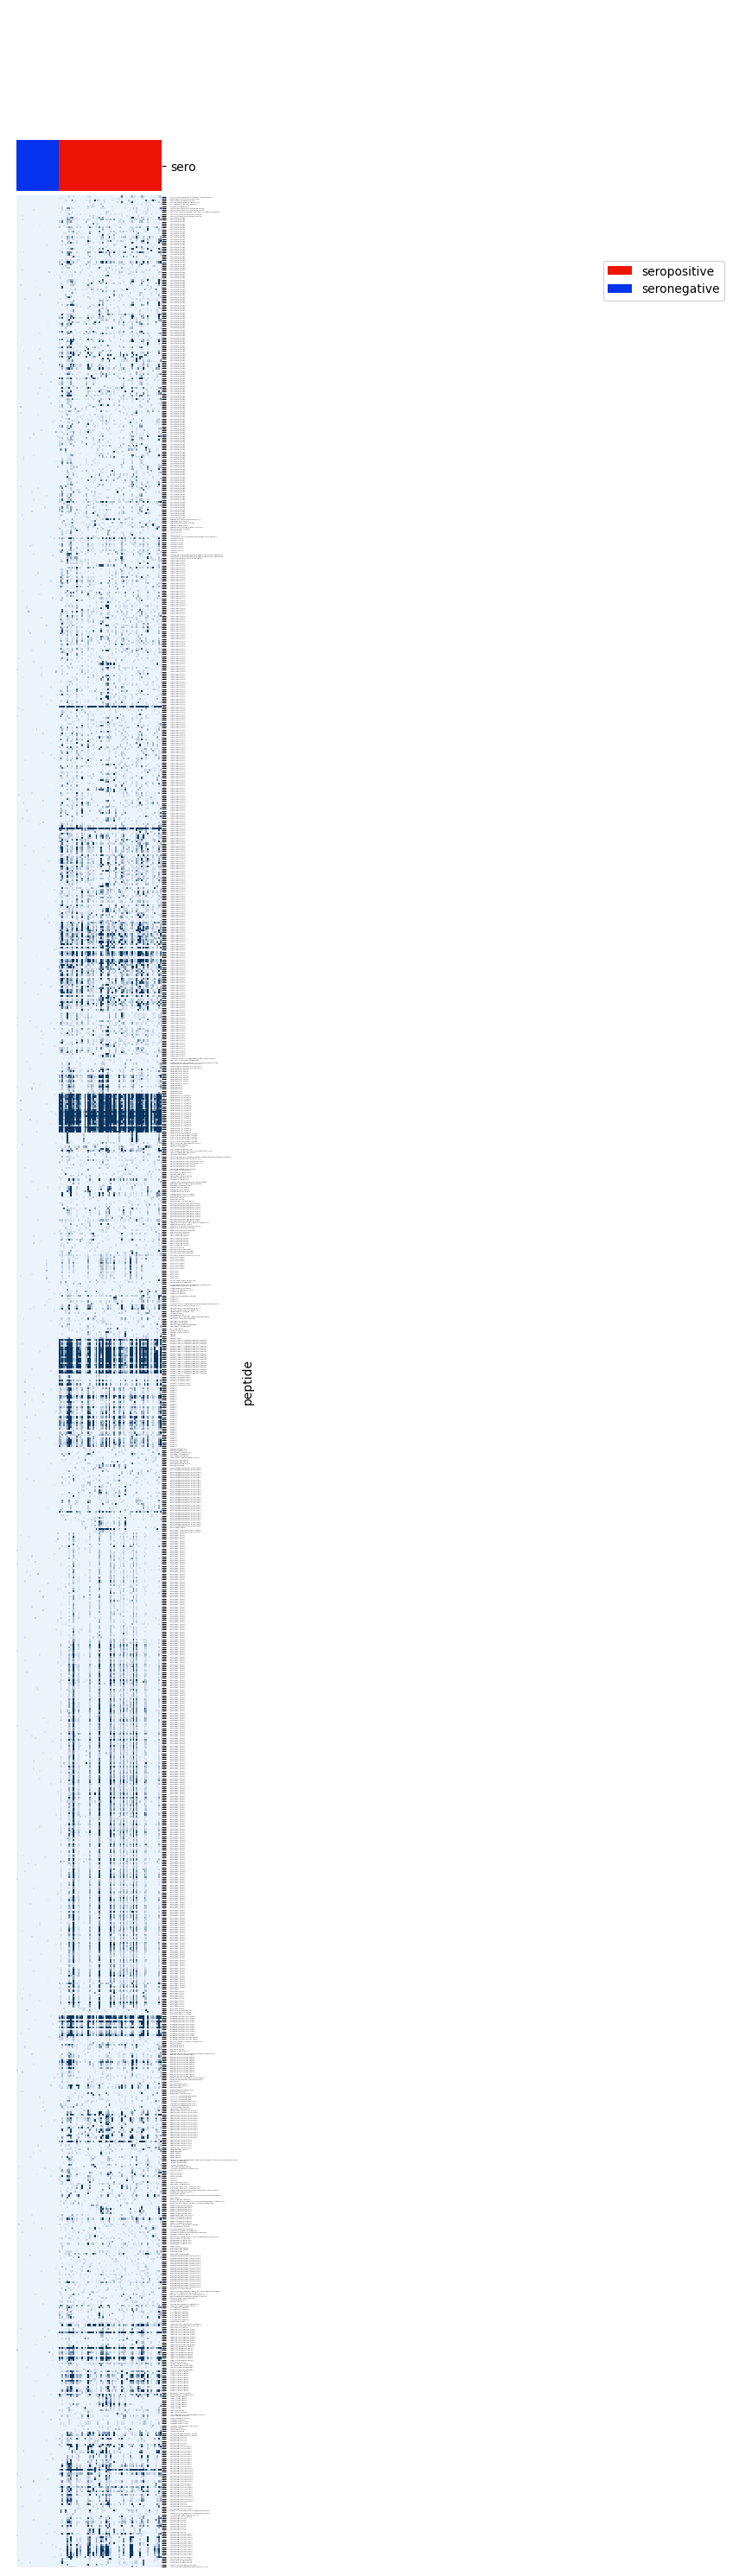

In [9]:
# plot heatmap with peptides in alphabetical order and serologic status labeled along top of heatmap

# label samples by serologic status
group=subset_bd.obs.sero
lut = dict(zip(group.unique(), ["#ed1405", "#0533ed"]))
col_colors = group.map(lut)

# label peptides with protein name
y_ticklabels=['{}'.format(filtered_bd.loc[i,'protein']) for i in bd_names]

# plot heatmap - no clustering, scale of 0-100
ax=sns.clustermap(df_bd, standard_scale=None, figsize=(10, 30), cbar_kws=None, row_cluster=False,
                  col_cluster=False, row_colors=None, vmin=0, vmax=100,
                  col_colors=col_colors, mask=None, dendrogram_ratio=0.05, colors_ratio=0.02,
                  yticklabels=y_ticklabels,
                  xticklabels=False, cmap=custom_cmap, cbar_pos=None)

# make labels small so they don't overlap
plt.yticks(fontsize=1)

# generate legend for column colors
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut,
           bbox_to_anchor=(.85, 0.9),
           bbox_transform=plt.gcf().transFigure,
           loc='upper right'
          )

plt.savefig(fig_dir+'fig_2a.pdf', dpi=300 , bbox_inches="tight")
plt.show()

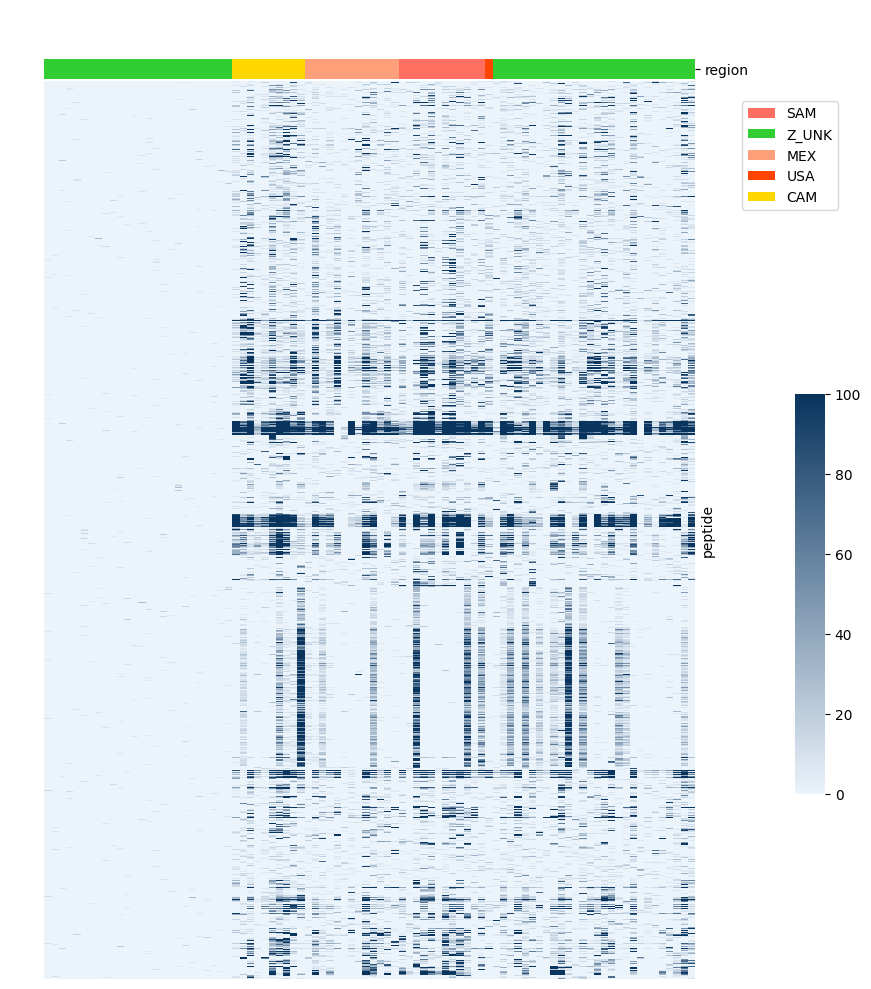

In [10]:
# generate a second heatmap with column colors by region

# label samples by region
group=subset_bd.obs.region

lut = dict(zip(group.unique(), [
    "#FF6F61", #Coral Red
    "#32CD32", #Lime Green
    "#FFA07A", #Light Salmon
    "#FF4500", #Orange Red
    "#FFD700", #Gold
]))
col_colors = group.map(lut)

# plot heatmap - no clustering, scale of 0-100
ax=sns.clustermap(df_bd, standard_scale=None, figsize=(10, 10), cbar_kws=None, row_cluster=False,
                  col_cluster=False, row_colors=None, vmin=0, vmax=100,
                  col_colors=col_colors, mask=None, dendrogram_ratio=0.05, colors_ratio=0.02,
                  yticklabels=False,
                  xticklabels=False, cmap=custom_cmap)

# show scale
ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

# generate legend for column colors
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut,
           bbox_to_anchor=(.85, 0.9),
           bbox_transform=plt.gcf().transFigure,
           loc='upper right'
          )

plt.savefig(fig_dir+'fig_2a_region.pdf', dpi=300 , bbox_inches="tight")
plt.show()

## CBM

In [11]:
# subset CBM-enriched peptides into only those reactive in at least 15% of specimens
filtered_cbm = chagas_pept_cbm[chagas_pept_cbm['perc_test'] > 15]
filtered_cbm.shape

(1101, 9)

In [12]:
# get list of peptide names - this list will correspond to var_names in adata object
cbm_names=filtered_cbm.sort_values(by='protein',ascending=False).index

# subset adata object for plotting - extract only seropos and seroneg samples, and only peptides enriched in seropos
subset_cbm = cbm[cbm.obs['sero'].isin(['seropositive', 'seronegative']), cbm_names]

# generate df for plotting - will contain sample ids, z-scores, and peptide names
df_cbm = pd.DataFrame(data=subset_cbm.layers['z_score'], 
                             index=subset_cbm.obs.index, 
                             columns=cbm_names)
df_cbm = df_cbm.T

# sort samples by serologic status and by heart disease stage
sorted_obs = subset_cbm.obs.sort_values(by=['group', 'heart_dz'], ascending=True)
df_cbm = df_cbm[sorted_obs.index]

# replace z-scores below 5 with 0 for clear plotting of negatives
df_cbm = df_cbm.where(df_cbm > 5, 0)

In [13]:
subset_cbm

View of AnnData object with n_obs × n_vars = 228 × 1101
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    uns: 'control_ids'
    obsm: 'DS_z_5'
    varm: 'X_control'
    layers: 'z_score'

/data/kortbawi/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:1107: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


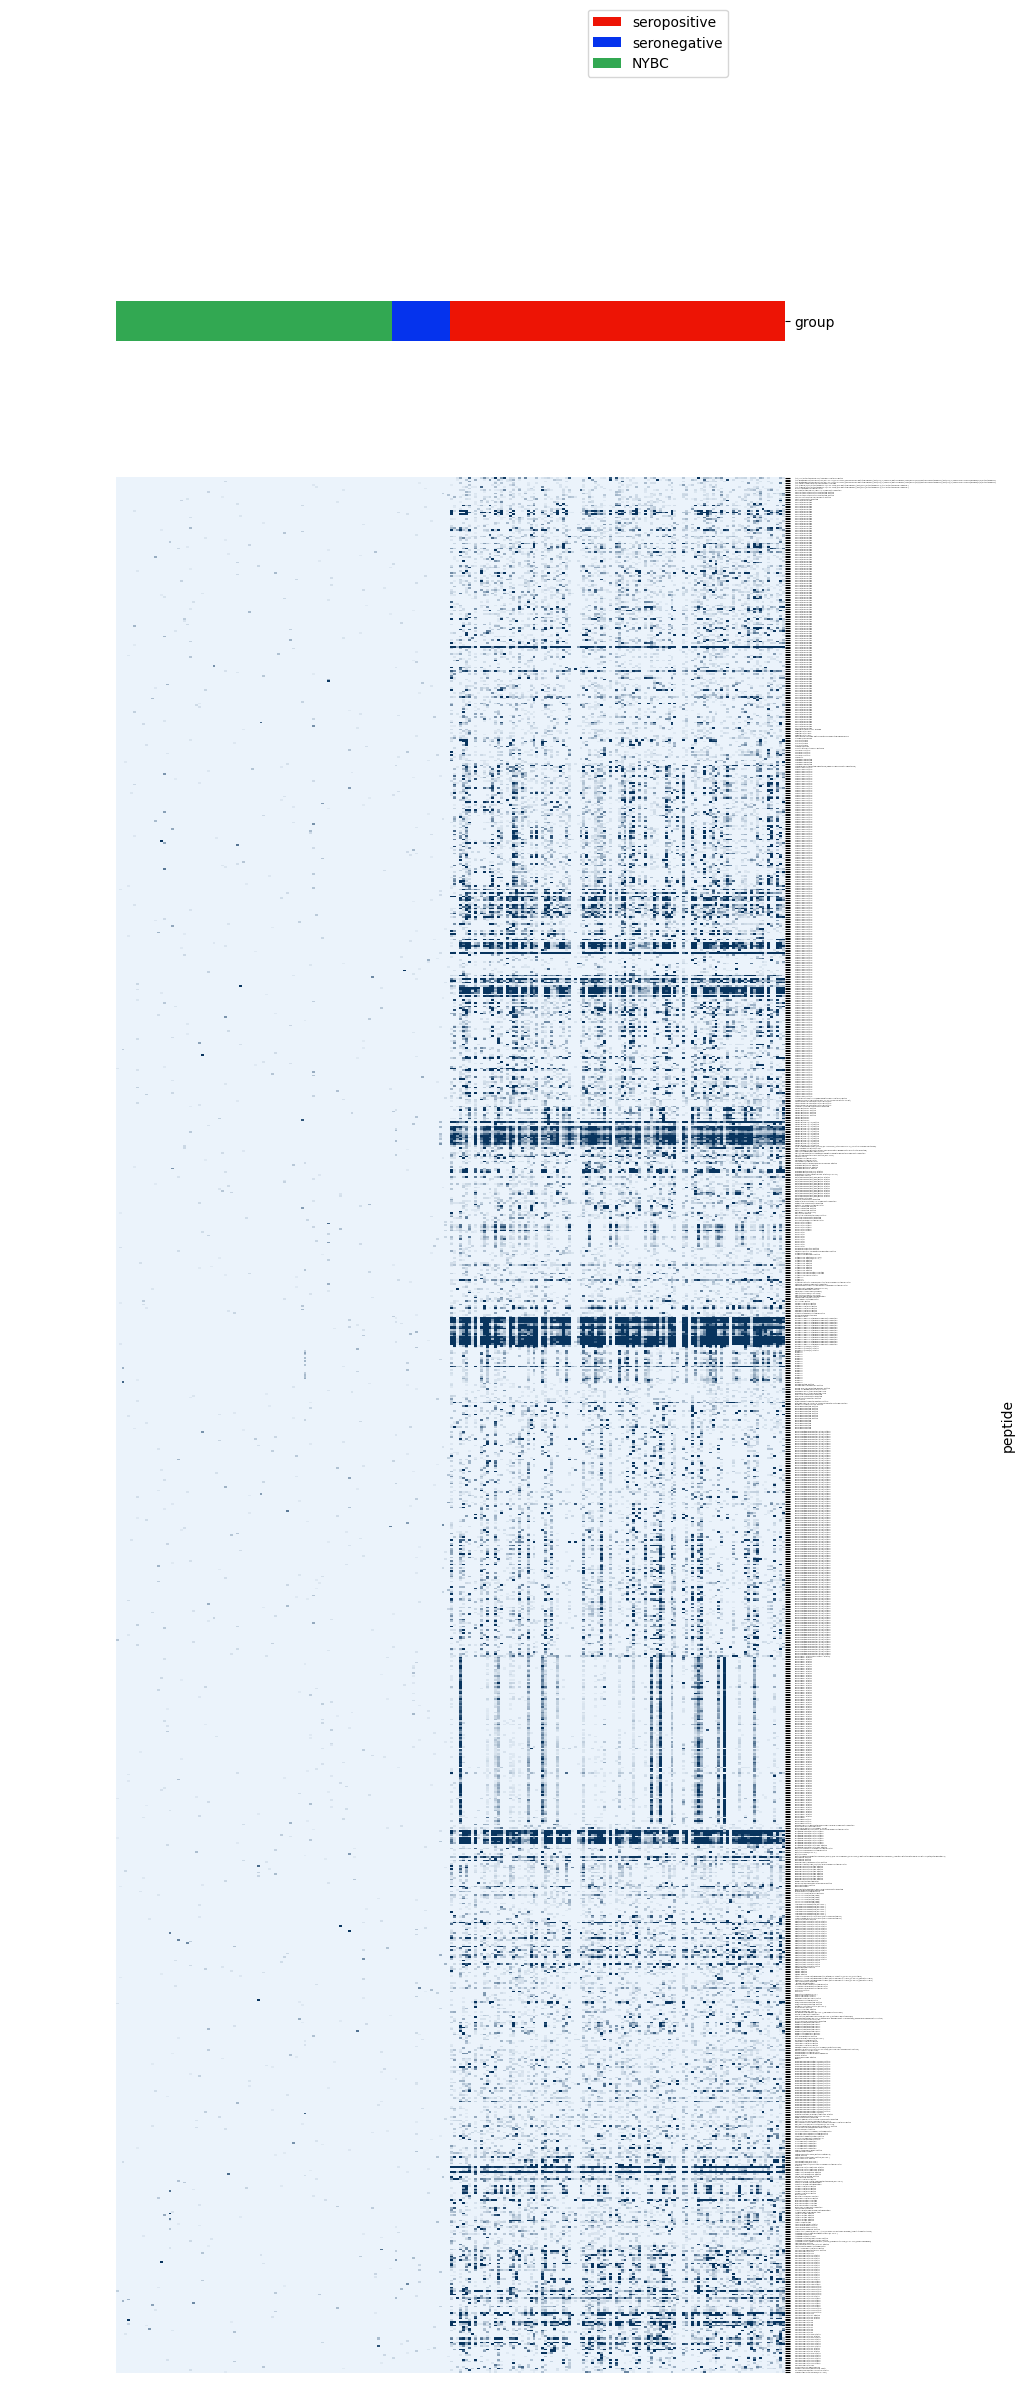

In [14]:
# plot heatmap with peptides in alphabetical order and serologic status labeled along top of heatmap

# label samples by serologic status (NYBC vs CBM seroneg vs CBM seropos)
group=subset_cbm.obs.group

lut = dict(zip(group.unique(), ["#ed1405", "#0533ed", "#32a852"]))
col_colors = group.map(lut)

# label peptides with protein name
y_ticklabels=['{}'.format(filtered_cbm.loc[i,'protein']) for i in cbm_names]

# plot heatmap - no clustering, scale of 0-100
ax=sns.clustermap(df_cbm, standard_scale=None, figsize=(10, 30), cbar_kws=None, row_cluster=False,
                  col_cluster=False, row_colors=None, vmin=0, vmax=100,
                  col_colors=col_colors, mask=None, dendrogram_ratio=0.05, colors_ratio=0.02,
                  yticklabels=y_ticklabels,
                  xticklabels=False, cmap=custom_cmap, cbar_pos=None)

# make labels small so they don't overlap
plt.yticks(fontsize=1)

# generate legend for column colors
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut,
           bbox_to_anchor=(.85, 0.9),
           bbox_transform=plt.gcf().transFigure,
           loc='upper right'
          )

plt.savefig(fig_dir+'fig_2b.pdf', dpi=300 , bbox_inches="tight")
plt.show()

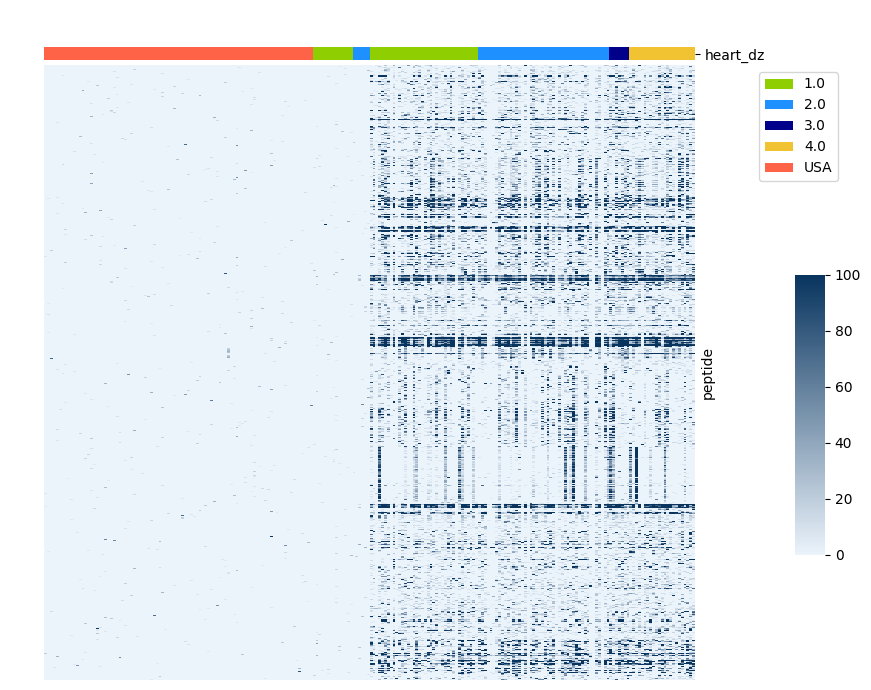

In [15]:
# generate a second heatmap with column colors by heart disease status

# label samples by heart disease
group=subset_cbm.obs.heart_dz

lut = dict(zip(group.unique(), [
    "#8FCE00",  # green
    "#1e90ff",  # dodgerblue
    "#00008b",  # darkblue
    "#F1C232",  # mustard
    "#FF6347",  # tomato
]))
col_colors = group.map(lut)

# plot heatmap - no clustering, scale of 0-100
ax=sns.clustermap(df_cbm, standard_scale=None, figsize=(10, 7), cbar_kws=None, row_cluster=False,
                  col_cluster=False, row_colors=None, vmin=0, vmax=100,
                  col_colors=col_colors, mask=None, dendrogram_ratio=0.05, colors_ratio=0.02,
                  yticklabels=False,
                  xticklabels=False, cmap=custom_cmap)

# show scale
ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

# generate legend for column colors
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut,
           bbox_to_anchor=(.85, 0.9),
           bbox_transform=plt.gcf().transFigure,
           loc='upper right'
          )

plt.savefig(fig_dir+'fig_2b_heartdz.pdf', dpi=300 , bbox_inches="tight")
plt.show()